- 2nd AE 실습

(수정된 신용카드 거래 소스올리면, 그걸 해보고 수행한후

응용해서 아래 실습)

1. DSA데이터에서 

lyingRigh                  480

lyingBack                  480
을 정상 (normal) jumping(abnormal)을 비정상 데이터로 사용

2. 두개 (lying+jumping) activity를 섞어서 test 

3. lying만 가지고 훈련하여 AE 구축

4. 테스트 데이터(lying+jumping)AE에 넣어서 Reconstruction error(입력/출력차이)를 구함

5. 적당한 threshold값으로 분류수행

6. accuracy를 구함

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("/Users/gim-yuseong/Desktop/PycharmProjects/2024_3_2/2024_3_2_딥러닝응용/DSA_features.csv")
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [3]:
df.shape

(9120, 272)

In [4]:
df.isnull().values.any()

False

In [5]:
df.columns

# 모든 열 이름을 리스트 형태로 출력
all_columns = df.columns.tolist()
print(all_columns)

['T_xacc_mean', 'T_xacc_max', 'T_xacc_min', 'T_xacc_var', 'T_xacc_std', 'T_xacc_skew', 'T_yacc_mean', 'T_yacc_max', 'T_yacc_min', 'T_yacc_var', 'T_yacc_std', 'T_yacc_skew', 'T_zacc_mean', 'T_zacc_max', 'T_zacc_min', 'T_zacc_var', 'T_zacc_std', 'T_zacc_skew', 'T_xgyro_mean', 'T_xgyro_max', 'T_xgyro_min', 'T_xgyro_var', 'T_xgyro_std', 'T_xgyro_skew', 'T_ygyro_mean', 'T_ygyro_max', 'T_ygyro_min', 'T_ygyro_var', 'T_ygyro_std', 'T_ygyro_skew', 'T_zgyro_mean', 'T_zgyro_max', 'T_zgyro_min', 'T_zgyro_var', 'T_zgyro_std', 'T_zgyro_skew', 'T_xmag_mean', 'T_xmag_max', 'T_xmag_min', 'T_xmag_var', 'T_xmag_std', 'T_xmag_skew', 'T_ymag_mean', 'T_ymag_max', 'T_ymag_min', 'T_ymag_var', 'T_ymag_std', 'T_ymag_skew', 'T_zmag_mean', 'T_zmag_max', 'T_zmag_min', 'T_zmag_var', 'T_zmag_std', 'T_zmag_skew', 'RA_xacc_mean', 'RA_xacc_max', 'RA_xacc_min', 'RA_xacc_var', 'RA_xacc_std', 'RA_xacc_skew', 'RA_yacc_mean', 'RA_yacc_max', 'RA_yacc_min', 'RA_yacc_var', 'RA_yacc_std', 'RA_yacc_skew', 'RA_zacc_mean', 'RA_zac

In [6]:
df['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

### 1.DSA데이터에서 lyingRigh, lyingBack을 정상 (normal) jumping(abnormal)을 비정상 데이터로 사용

In [7]:
df_filtered = df[df['activity'].isin(['lyingRigh','lyingBack','jumping'])]
df_filtered = df_filtered.drop('people', axis=1)
df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
960,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.41744,-0.59561,0.001016,...,9.725263e-07,0.000986,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,lyingBack
961,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.40372,-0.63184,0.001297,...,6.211659e-07,0.000788,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,lyingBack
962,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.42616,-0.59561,0.000863,...,4.579046e-07,0.000677,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,lyingBack
963,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.30877,-0.55225,0.003587,...,4.703523e-07,0.000686,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,lyingBack
964,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.38900,-0.53714,0.001059,...,5.467316e-07,0.000739,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,lyingBack


In [8]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 'label' 컬럼을 숫자로 변환
df_filtered['activity'] = label_encoder.fit_transform(df_filtered['activity'])

df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
960,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.41744,-0.59561,0.001016,...,9.725263e-07,0.000986,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,1
961,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.40372,-0.63184,0.001297,...,6.211659e-07,0.000788,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,1
962,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.42616,-0.59561,0.000863,...,4.579046e-07,0.000677,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,1
963,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.30877,-0.55225,0.003587,...,4.703523e-07,0.000686,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,1
964,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.38900,-0.53714,0.001059,...,5.467316e-07,0.000739,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,1


In [9]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 열 이름의 접두사/접미사를 사용하여 필터링
prefixes = ['T_', 'RA_', 'LA_', 'RL_', 'LL_']  # 원하는 접두사 리스트
columns_to_scale = df_filtered.columns[df_filtered.columns.str.startswith(tuple(prefixes))]

# 선택한 열을 스케일링
df_filtered[columns_to_scale] = scaler.fit_transform(df_filtered[columns_to_scale])

# 스케일링 후 데이터 확인
df_filtered.head()


,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
960,-1.300800,-0.841807,-0.383446,-0.588444,-0.668782,0.594503,0.707199,0.198016,1.117672,-0.504629,...,-0.419754,-0.644095,-0.074754,-0.657309,-0.694633,-0.622900,-0.293717,-0.562838,-0.339489,1
961,-1.290874,-0.835262,-0.378146,-0.588409,-0.663615,1.279953,0.712412,0.200431,1.109881,-0.504552,...,-0.419913,-0.651973,-0.628225,-0.654486,-0.693653,-0.619895,-0.293803,-0.567634,-0.647722,1
962,-1.295223,-0.841081,-0.376233,-0.588440,-0.667907,0.762443,0.709010,0.196480,1.117672,-0.504672,...,-0.419987,-0.656407,-0.804482,-0.653352,-0.692413,-0.617141,-0.293909,-0.574547,0.312657,1
963,-1.285297,-0.834507,-0.381680,-0.588403,-0.662936,0.721776,0.723454,0.217149,1.126996,-0.503919,...,-0.419982,-0.656043,-0.367691,-0.654481,-0.694060,-0.618316,-0.293917,-0.575131,-0.256905,1
964,-1.289787,-0.839630,-0.368921,-0.588445,-0.668899,0.093760,0.717811,0.203023,1.130245,-0.504618,...,-0.419947,-0.653911,0.489375,-0.651906,-0.689323,-0.617700,-0.293573,-0.555757,-0.051995,1


In [10]:
df_filtered['activity'].value_counts()

activity
1    480
2    480
0    480
Name: count, dtype: int64

In [11]:
LABELS = ["Normal", "Abnormal"]

In [12]:
normal1 = df_filtered[df_filtered.activity == 1]
normal2 = df_filtered[df_filtered.activity == 2]
abnormal = df_filtered[df_filtered.activity == 0]
normal1.shape

(480, 271)

In [13]:
normal1.shape

(480, 271)

In [14]:
abnormal.shape

(480, 271)

### 2. 두개 (lying+jumping) activity를 섞어서 test 

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df_filtered, test_size=0.2, random_state=20)

X_train.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
1211,-1.107711,-0.790236,-0.140025,-0.588425,-0.665642,-1.006005,0.685336,0.178655,1.103674,-0.504779,...,-0.419929,-0.652858,0.590352,1.541768,1.457842,1.619521,-0.293913,-0.574816,0.145246,1
1494,0.039689,-0.487753,1.401052,-0.588450,-0.670146,-0.805721,-1.087413,-1.035136,-0.399319,-0.504419,...,-0.419981,-0.655974,-0.593897,-0.357206,-0.402484,-0.315593,-0.293916,-0.575048,-0.363303,2
1603,0.386112,-0.394804,1.859089,-0.588447,-0.669394,-0.624054,-1.380101,-1.239344,-0.644101,-0.504629,...,-0.419861,-0.649167,-1.186963,-0.643317,-0.681829,-0.608667,-0.293505,-0.552756,-0.383102,2
1215,-1.124111,-0.794271,-0.158354,-0.588425,-0.665597,0.555743,0.694247,0.189245,1.106889,-0.504677,...,-0.419975,-0.655599,-0.058546,1.542267,1.457786,1.620233,-0.293906,-0.574352,0.466931,1
8459,1.309536,1.808045,-1.975362,2.697161,2.175758,1.192669,0.669618,0.467325,0.391219,-0.161989,...,0.715580,1.307925,-0.306605,0.901123,0.878021,0.903389,-0.192565,0.080548,-0.341484,0


In [16]:
y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)

X_test

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
1587,0.396134,-0.391136,1.873933,-0.588445,-0.668790,-0.086238,-1.374188,-1.231474,-0.637822,-0.504583,...,1.591482,-0.419559,-0.636198,-0.377677,-0.658288,-0.695707,-0.626559,-0.293194,-0.540725,-0.771997
1863,0.068236,-0.481237,1.448407,-0.588456,-0.672145,0.493890,-1.559587,-1.372825,-0.780137,-0.504839,...,-1.523154,-0.384499,-0.330314,-0.219088,-0.431500,-0.416362,-0.467147,-0.256577,-0.188839,-0.711137
1711,-0.520372,-0.638096,0.659743,-0.588454,-0.671281,-0.924973,-1.654466,-1.429098,-0.866218,-0.504708,...,-0.845934,-0.420000,-0.657276,0.338874,-0.812424,-0.847767,-0.779096,-0.293933,-0.576331,0.211823
1380,-0.726025,-0.691080,0.381192,-0.588442,-0.668370,0.513927,0.271862,-0.099434,0.743135,-0.504441,...,0.479414,-0.386019,-0.337913,0.242649,-0.846660,-0.832021,-0.864204,-0.268681,-0.262724,0.059097
1281,-1.245761,-0.829677,-0.309863,-0.588447,-0.669313,-0.238470,0.536431,0.076621,0.975617,-0.504611,...,0.650023,-0.419933,-0.653118,0.383333,-0.861812,-0.893785,-0.837683,-0.291583,-0.497906,-0.986294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8582,1.338216,0.981656,-0.137400,0.860099,1.217968,0.604104,0.223102,0.436122,-0.488798,1.205060,...,0.074698,-0.113080,0.352128,1.189781,1.475559,1.495718,1.450209,0.003766,0.570362,0.887133
1204,-1.039865,-0.748916,-0.163653,-0.587387,-0.623225,-1.624778,0.724041,0.233924,1.093011,-0.499496,...,0.455516,-0.419816,-0.646965,-0.744300,1.539560,1.454863,1.616535,-0.293826,-0.569029,0.032772
1240,-1.117668,-0.792462,-0.151115,-0.588432,-0.666571,-0.865311,0.703186,0.191474,1.119420,-0.504734,...,0.427577,-0.420010,-0.657920,-0.514208,1.550014,1.464429,1.627571,-0.293910,-0.574609,-0.394468
8311,1.401687,0.771873,-0.097284,0.234440,0.751828,0.552664,0.711994,0.590629,0.254925,-0.278703,...,-1.178540,0.223028,0.815188,1.082522,-0.296010,-0.157056,-0.407712,0.484169,1.295932,0.314456


In [17]:
# X_train과 X_test를 넘파이 배열로 변환
X_train = X_train.values
X_test = X_test.values

X_train

array([[-1.10771127e+00, -7.90235744e-01, -1.40025200e-01, ...,
        -5.74815957e-01,  1.45246187e-01,  1.00000000e+00],
       [ 3.96886775e-02, -4.87752719e-01,  1.40105220e+00, ...,
        -5.75048464e-01, -3.63303326e-01,  2.00000000e+00],
       [ 3.86111838e-01, -3.94803585e-01,  1.85908899e+00, ...,
        -5.52756340e-01, -3.83101922e-01,  2.00000000e+00],
       ...,
       [-1.11664274e+00, -7.92441932e-01, -1.51017298e-01, ...,
        -5.71728531e-01,  1.10743583e-03,  1.00000000e+00],
       [-7.10958063e-01, -6.88692284e-01,  4.09162581e-01, ...,
        -1.90494998e-01,  6.13305816e-01,  1.00000000e+00],
       [ 1.33909956e+00,  2.83421668e+00, -1.96800126e+00, ...,
         8.65452941e-01,  3.75387077e-01,  0.00000000e+00]])

### 3. lying만 가지고 훈련하여 AE 구축

In [18]:
input_dim = X_train.shape[1]
encoding_dim = 16  # 인코딩 차원을 설정 (임의로 설정한 값, 조정 가능)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim /2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 271)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 271)            │         2,439 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,999 (27.34 KB)

 Trainable params: 6,999 (27.34 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# 3. 모델 학습
# 훈련데이터의 0.1 을 validation data로 사용
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_split = 0.1)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.2172 - val_loss: 1.2579
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2328 - val_loss: 1.2504
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2262 - val_loss: 1.2387
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2015 - val_loss: 1.2226
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2089 - val_loss: 1.2027
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1825 - val_loss: 1.1803
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1631 - val_loss: 1.1564
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1274 - val_loss: 1.1309
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0749 - val_loss: 1.1039
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0741 - val_loss: 1.0749
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0376 - val_loss: 1.0447
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0296 - val_loss: 1.0137
Epoch 13/50


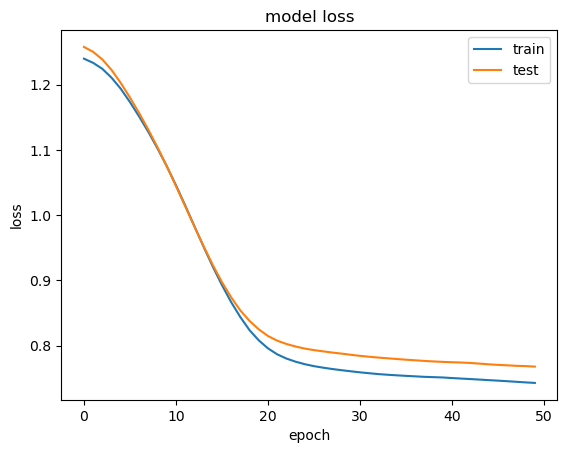

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

##  4. 테스트 데이터(lying+jumping)AE에 넣어서 Reconstruction error(입력/출력차이)를 구함

In [34]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# 1. 데이터 준비 (여기서 271개의 특성을 갖는 데이터 사용)
lyingRight = np.random.rand(480, 271)  # 정상 데이터
lyingBack = np.random.rand(480, 271)   # 정상 데이터
jumping = np.random.rand(480, 271)     # 비정상 데이터

normal_data = np.vstack((lyingRight, lyingBack))  # 정상 데이터
abnormal_data = jumping                            # 비정상 데이터

# 데이터셋 분할
X_train, X_valid = train_test_split(normal_data, test_size=0.2, random_state=42)
y_train = X_train  # Autoencoder에서 y는 X와 동일
y_valid = X_valid  # Autoencoder에서 y는 X와 동일

# 2. Autoencoder 구축
input_dim = normal_data.shape[1]  # 특징 수: 271
input_layer = Input(shape=(input_dim,))
encoder = Dense(10, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# 3. 모델 학습
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # 조기 종료
history = autoencoder.fit(X_train, y_train, 
                          epochs=25, 
                          batch_size=256, 
                          shuffle=True, 
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping])

# 4. 테스트 데이터 준비 (X_test)
# 정상 및 비정상 데이터 각각 32개 선택
X_test = np.vstack((normal_data[:32], abnormal_data[:32]))  # 정상과 비정상 데이터 결합
y_test = np.array([0] * 32 + [1] * 32)  # 레이블: 정상(0), 비정상(1)

# X_test의 형태 확인
print(f'X_test shape: {X_test.shape}')  # (64, 271)

# 5. Reconstruction Error 계산
predictions = autoencoder.predict(X_test)  # X_test에 대한 예측
print(f'Predictions shape: {predictions.shape}')  # (64, 271)

# mse 계산
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

# 6. 데이터프레임 구성
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

# 7. 결과 확인
error_df.describe()


Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0841 - val_loss: 0.0837
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0837 - val_loss: 0.0835
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0834 - val_loss: 0.0835
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0832 - val_loss: 0.0835
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0832 - val_loss: 0.0835
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0832 - val_loss: 0.0835
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0832 - val_loss: 0.0835
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0832 - val_loss: 0.0835
Epoch 9/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0832 - val_loss: 0.0835
Epoch 10/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0832 - val_loss: 0.0835
Epoch 11/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0832 - val_loss: 0.0835
Epoch 12/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0832 - val_loss: 0.0834
Epoch 13/25


,reconstruction_error,true_class
count,64.000000,64.000000
mean,0.083291,0.500000
std,0.004322,0.503953
min,0.073164,0.000000
25%,0.080263,0.000000
50%,0.082898,0.500000
75%,0.086043,1.000000
max,0.093630,1.000000


In [35]:
error_df = error_df.reset_index(drop=True)
error_df

,reconstruction_error,true_class
0,0.079120,0
1,0.080353,0
2,0.083663,0
3,0.088204,0
4,0.085057,0
...,...,...
59,0.085720,1
60,0.089109,1
61,0.090574,1
62,0.086566,1


## 5. 적당한 threshold값으로 분류수행

In [36]:
threshold = 1.5

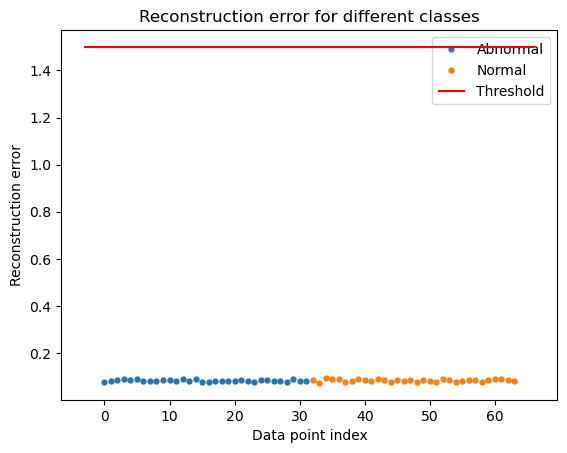

In [37]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Normal" if name == 1 else "Abnormal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## 6. accuracy를 구함

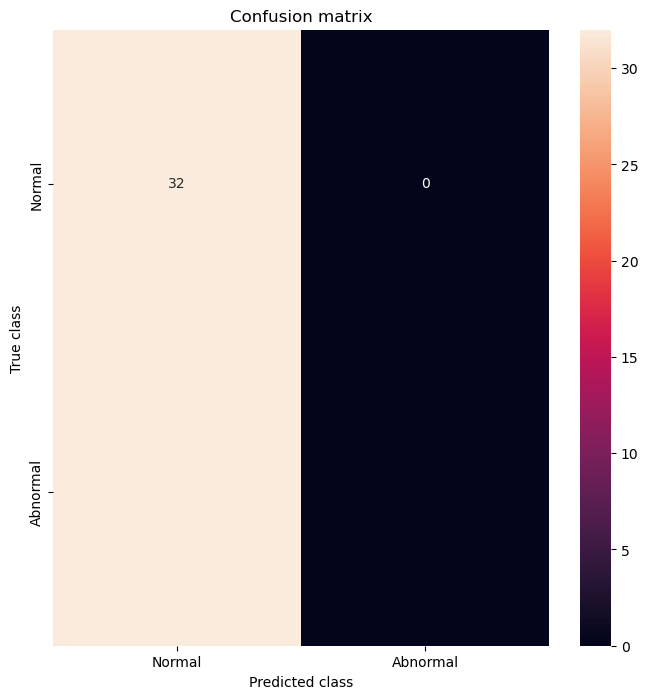

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        32
           1       0.00      0.00      0.00        32

    accuracy                           0.50        64
   macro avg       0.25      0.50      0.33        64
weighted avg       0.25      0.50      0.33        64



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred))